# Final Projects 90-803: MLFP Spring 2023
## Team 9
### Question 2: We have a binary variable that indicates whether serious injuries were involved in the accident. Are the injuries related to the driver's behavior, e.g. drug, alcohol etc.?
Classification - target variable: INJURY_OR_FATAL

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

Load and check that there are no missing values in your dataset. 

In [3]:
df2=pd.read_csv("Q2.csv")
df2.head()

,Unnamed: 0,AGGRESSIVE_DRIVING,ALCOHOL_RELATED,CELL_PHONE,CORE_NETWORK,CURVED_ROAD,DISTRACTED,DRUGGED_DRIVER,YOUNG_DRIVER,MATURE_DRIVER,SPEEDING_RELATED,URBAN,INJURY_OR_FATAL
0,0,1,0,0,0,0,0,0,0,0,0,1,1
1,1,1,0,0,0,0,0,0,1,1,0,1,0
2,2,1,0,0,0,0,0,0,1,0,0,1,1
3,3,1,0,0,0,0,0,0,1,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,0,1,1


In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604651 entries, 0 to 604650
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   Unnamed: 0          604651 non-null  int64
 1   AGGRESSIVE_DRIVING  604651 non-null  int64
 2   ALCOHOL_RELATED     604651 non-null  int64
 3   CELL_PHONE          604651 non-null  int64
 4   CORE_NETWORK        604651 non-null  int64
 5   CURVED_ROAD         604651 non-null  int64
 6   DISTRACTED          604651 non-null  int64
 7   DRUGGED_DRIVER      604651 non-null  int64
 8   YOUNG_DRIVER        604651 non-null  int64
 9   MATURE_DRIVER       604651 non-null  int64
 10  SPEEDING_RELATED    604651 non-null  int64
 11  URBAN               604651 non-null  int64
 12  INJURY_OR_FATAL     604651 non-null  int64
dtypes: int64(13)
memory usage: 60.0 MB


Drop useless column

In [5]:
df2.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df2.isna().sum()

AGGRESSIVE_DRIVING    0
ALCOHOL_RELATED       0
CELL_PHONE            0
CORE_NETWORK          0
CURVED_ROAD           0
DISTRACTED            0
DRUGGED_DRIVER        0
YOUNG_DRIVER          0
MATURE_DRIVER         0
SPEEDING_RELATED      0
URBAN                 0
INJURY_OR_FATAL       0
dtype: int64

Correct data type and no missing values

## EDA

#### Plot a correlation matrix heatmap to examine the correlations between different variables

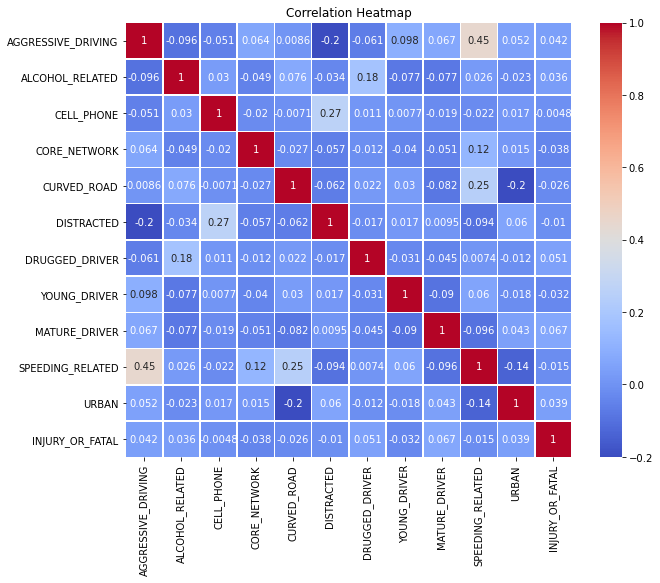

In [7]:
data = df2.copy()
# Compute the correlation matrix
corr_matrix = data.corr()

# Create a correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Only variable SPEEDING_RELATED and AGGRESSIVE_DRIVING are correlated(0.45).
The correlation between most of the variables is less than 0.1. There is no strong correlation between variables, indicating that the effect of multicollinearity can be excluded between variables.

#### Bar plot for counts of injury or fatal accidents by factors

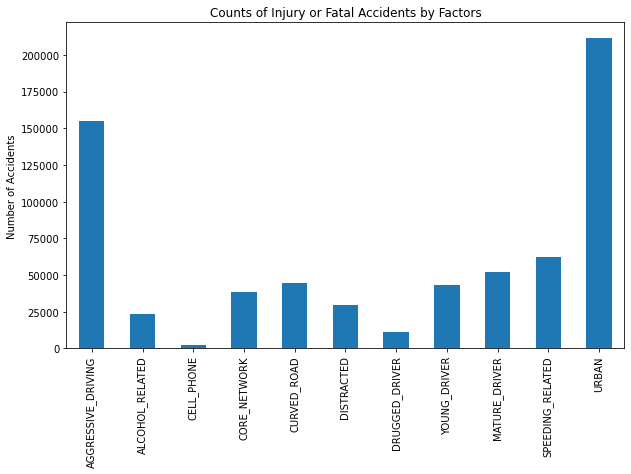

In [8]:
# Filter only the rows with injury or fatal accidents
injury_fatal_data = data[data['INJURY_OR_FATAL'] == 1]

# Calculate the sum of each factor
factors = ['AGGRESSIVE_DRIVING', 'ALCOHOL_RELATED', 'CELL_PHONE', 'CORE_NETWORK', 'CURVED_ROAD', 'DISTRACTED', 'DRUGGED_DRIVER', 'YOUNG_DRIVER', 'MATURE_DRIVER', 'SPEEDING_RELATED', 'URBAN']
sums = injury_fatal_data[factors].sum()

# Create a bar plot
sums.plot(kind='bar', figsize=(10, 6))
plt.title('Counts of Injury or Fatal Accidents by Factors')
plt.ylabel('Number of Accidents')
plt.show()

The bar chart indicates that among the crashes where at least one person was injured or killed, there were more crashes that occurred in urban areas or involved at least one aggressive driver. Conversely, fewer crashes where at least one person was injured or killed were attributed to cell phone use. 

In order to investigate the proportion of crashes that occurred in urban areas, we choose to plot a pie chart.

#### Pie chart for urban and non-urban injury or fatal accidents

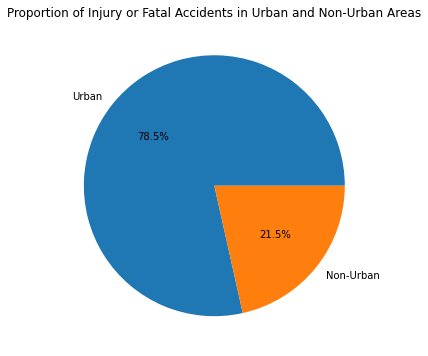

In [9]:
# Filter only the rows with injury or fatal accidents
injury_fatal_data = data[data['INJURY_OR_FATAL'] == 1]

# Calculate the number of urban and non-urban injury or fatal accidents
urban_count = injury_fatal_data['URBAN'].sum()
non_urban_count = len(injury_fatal_data) - urban_count

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie([urban_count, non_urban_count], labels=['Urban', 'Non-Urban'], autopct='%1.1f%%')
plt.title('Proportion of Injury or Fatal Accidents in Urban and Non-Urban Areas')
plt.show()

The proportion of urban crashes among all injury or fatality crashes is around 78.5%, this may suggest that location is indeed a significant factor contributing to crashes. However, this may be due to the traffic density of the city, etc., and does not indicate causality.

## Feature Engineering

In [10]:
num_rows = df2.shape[0]
print("number of rows：", num_rows)

number of rows： 604651


Given the large size of our dataset, we employed techniques to mitigate the computational burden and expedite the model training. Specifically, we randomly shuffled the data and selected a subset of 10,000 samples. By doing so, we reduced the amount of data that the model has to process, which can help accelerate the training process.

In [11]:
# Shuffle the dataset
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Select the first 10,000 rows
selected_data = shuffled_data.head(10000)

In [12]:
# Check the value counts for the INJURY_OR_FATAL column
print(selected_data['INJURY_OR_FATAL'].value_counts())

0    5574
1    4426
Name: INJURY_OR_FATAL, dtype: int64


the classes of labels are relatively balanced.

In [13]:
# Separate the features and target
X = selected_data.drop("INJURY_OR_FATAL", axis=1)
y = selected_data["INJURY_OR_FATAL"]

# Print the shapes of X
print(X.shape)

(10000, 11)


## Model Training

Split X and y into X_train, X_test, y_train and y_test. Use a 80-20 ratio for the split and a random_state=42.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 1. Naive Bayes

In [16]:
# Create a Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

# Train the model
gnb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gnb = gnb_classifier.predict(X_test)

# Calculate the accuracy
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print("Accuracy (Gaussian Naive Bayes): {:.2f}%".format(accuracy_gnb * 100))

# Print the classification report
print("\nClassification Report (Gaussian Naive Bayes):")
print(classification_report(y_test, y_pred_gnb))

# Print the confusion matrix
print("\nConfusion Matrix (Gaussian Naive Bayes):")
print(confusion_matrix(y_test, y_pred_gnb))

Accuracy (Gaussian Naive Bayes): 58.90%

Classification Report (Gaussian Naive Bayes):
              precision    recall  f1-score   support

           0       0.60      0.80      0.69      1137
           1       0.54      0.31      0.40       863

    accuracy                           0.59      2000
   macro avg       0.57      0.56      0.54      2000
weighted avg       0.58      0.59      0.56      2000


Confusion Matrix (Gaussian Naive Bayes):
[[908 229]
 [593 270]]


The overall accuracy of the model is 58.9%, a moderate level of accuracy. The precision and recall for class 0 (no injuries at all) are 0.60 and 0.80 respectively, with an F1-score of 0.69. For class 1 (at least one injury  or fatality), the precision and recall scores are 0.54 and 0.31 respectively, with an F1-score of 0.40. The model performs better on class 0 than class 1. 

#### 2. Random Forest

In [17]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto'],
    'bootstrap': [True]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the Grid Search object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# Fit the Grid Search object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found by Grid Search:")
print(grid_search.best_params_)

# Evaluate the best model on the test set
y_pred_rf = grid_search.predict(X_test)

# Calculate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy (Random Forest with Grid Search): {:.2f}%".format(accuracy_rf * 100))

# Print the classification report
print("\nClassification Report (Random Forest with Grid Search):")
print(classification_report(y_test, y_pred_rf))

# Print the confusion matrix
print("\nConfusion Matrix (Random Forest with Grid Search):")
print(confusion_matrix(y_test, y_pred_rf))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters found by Grid Search:
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy (Random Forest with Grid Search): 59.00%

Classification Report (Random Forest with Grid Search):
              precision    recall  f1-score   support

           0       0.60      0.83      0.70      1137
           1       0.55      0.27      0.36       863

    accuracy                           0.59      2000
   macro avg       0.58      0.55      0.53      2000
weighted avg       0.58      0.59      0.55      2000


Confusion Matrix (Random Forest with Grid Search):
[[948 189]
 [631 232]]


The overall accuracy of the model is 59%, which is almost the same as the Gaussian Naive Bayes model. For class 0 (no injuries), the precision, recall, and F1-score are 0.60, 0.83, and 0.70, respectively. For class 1 (at least one injury or fatality), these values are 0.55, 0.27, and 0.36, respectively. As a result, the model still performs better on class 0 than class 1.

#### 3. Neural Network

In [18]:
# Neural Network

param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,)], 
    'activation': ['relu']}

nn_grid = GridSearchCV(MLPClassifier(max_iter=200), param_grid_nn, cv=5)
nn_grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found by Grid Search (NN):")
print(nn_grid.best_params_)

# Evaluate the best model on the test set
y_pred_nn = nn_grid.predict(X_test)

# Calculate the accuracy
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print("Accuracy (NN with Grid Search): {:.2f}%".format(accuracy_nn * 100))

# Print the classification report
print("\nClassification Report (NN with Grid Search):")
print(classification_report(y_test, y_pred_nn))

# Print the confusion matrix
print("\nConfusion Matrix (NN with Grid Search):")
print(confusion_matrix(y_test, y_pred_nn))


Best parameters found by Grid Search (NN):
{'activation': 'relu', 'hidden_layer_sizes': (50,)}
Accuracy (NN with Grid Search): 59.40%

Classification Report (NN with Grid Search):
              precision    recall  f1-score   support

           0       0.60      0.83      0.70      1137
           1       0.56      0.28      0.37       863

    accuracy                           0.59      2000
   macro avg       0.58      0.56      0.54      2000
weighted avg       0.58      0.59      0.56      2000


Confusion Matrix (NN with Grid Search):
[[949 188]
 [624 239]]


The model's overall accuracy is 59.4%, which is slightly higher than previous models. Precision, recall, and F1-score for class 0 are 0.60, 0.83, and 0.70, respectively. The corresponding values for class 1 are 0.56, 0.28, and 0.37. Similar to the previous models, this model performs better on class 0 than class 1. The Neural Network model has a slightly better performance than the Gaussian Naive Bayes and Random Forest models. However, the overall performance is still moderate.

#### 4. KNN

In [19]:
# Define the parameter grid for Grid Search
param_grid_knn = {
    'n_neighbors': list(range(3, 11)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'brute']
}

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Create the Grid Search object
grid_search_knn = GridSearchCV(estimator=knn_classifier, param_grid=param_grid_knn, cv=3, verbose=2, n_jobs=-1)

# Fit the Grid Search object to the data
grid_search_knn.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found by Grid Search (KNN):")
print(grid_search_knn.best_params_)

# Evaluate the best model on the test set
y_pred_knn = grid_search_knn.predict(X_test)

# Calculate the accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy (KNN with Grid Search): {:.2f}%".format(accuracy_knn * 100))

# Print the classification report
print("\nClassification Report (KNN with Grid Search):")
print(classification_report(y_test, y_pred_knn))

# Print the confusion matrix
print("\nConfusion Matrix (KNN with Grid Search):")
print(confusion_matrix(y_test, y_pred_knn))


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters found by Grid Search (KNN):
{'algorithm': 'brute', 'n_neighbors': 10, 'weights': 'uniform'}
Accuracy (KNN with Grid Search): 57.90%

Classification Report (KNN with Grid Search):
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1137
           1       0.52      0.26      0.35       863

    accuracy                           0.58      2000
   macro avg       0.56      0.54      0.52      2000
weighted avg       0.56      0.58      0.54      2000


Confusion Matrix (KNN with Grid Search):
[[930 207]
 [635 228]]


The overall accuracy of the model is 57.9%, which is lower than the previous models. For class 0, the precision, recall, and F1-score are 0.59, 0.82, and 0.69, respectively. For class 1, these values are 0.52, 0.26, and 0.35, respectively. Similar to the previous models, this model performs better on class 0 than class 1. 

#### 5. Logistic Regression

In [21]:
# Logistic Regression
param_grid = {
    'C': [0.1,0.05],
    'max_iter': [1000, 500, 300]
}
lr_grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
lr_grid.fit(X_train, y_train)

y_pred_lr = lr_grid.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy (LR with Grid Search): {:.2f}%".format(accuracy_lr * 100))

print("Logistic Regression - Best parameters:", lr_grid.best_params_)
print(classification_report(y_test, lr_grid.predict(X_test)))

Accuracy (LR with Grid Search): 58.90%
Logistic Regression - Best parameters: {'C': 0.1, 'max_iter': 1000}
              precision    recall  f1-score   support

           0       0.60      0.85      0.70      1137
           1       0.55      0.24      0.34       863

    accuracy                           0.59      2000
   macro avg       0.58      0.55      0.52      2000
weighted avg       0.58      0.59      0.54      2000



 The overall accuracy of the model is 58.9%, which is slightly lower than the Neural Network model (59.4%). For class 0, the precision, recall, and F1-score are 0.60, 0.85, and 0.70, respectively. For class 1, these values are 0.55, 0.24, and 0.34, respectively. This model also performs better on class 0 than class 1.

### Comparing the classification results of each model.

In [22]:
metrics = {}

models = {
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
}

metrics['Naive Bayes'] = {
    'Precision': precision_score(y_test, y_pred_gnb),
    'Recall': recall_score(y_test, y_pred_gnb),
    'F1-score': f1_score(y_test, y_pred_gnb),
    'Accuracy': accuracy_score(y_test, y_pred_gnb)
}

metrics['Random Forest'] = {
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-score': f1_score(y_test, y_pred_rf),
    'Accuracy': accuracy_score(y_test, y_pred_rf)
}

metrics['NN'] = {
    'Precision': precision_score(y_test, y_pred_nn),
    'Recall': recall_score(y_test, y_pred_nn),
    'F1-score': f1_score(y_test, y_pred_nn),
    'Accuracy': accuracy_score(y_test,y_pred_nn)
}


metrics['KNN'] = {
    'Precision': precision_score(y_test, y_pred_knn),
    'Recall': recall_score(y_test, y_pred_knn),
    'F1-score': f1_score(y_test, y_pred_knn),
    'Accuracy': accuracy_score(y_test,y_pred_knn)
}


metrics['Logistic Regression'] = {
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-score': f1_score(y_test, y_pred_lr),
    'Accuracy': accuracy_score(y_test,y_pred_lr)
}


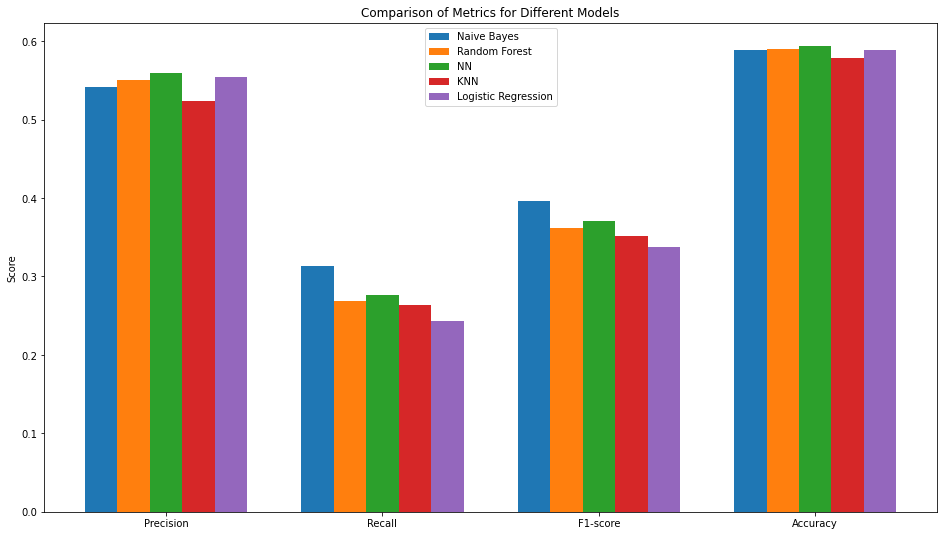

In [25]:
# Create the bar plot
n_metrics = len(metrics[list(models.keys())[0]])
n_models = 5

ind = np.arange(n_metrics)
width = 0.15

fig, ax = plt.subplots(figsize = (16,9))
for i, (model_name, model_metrics) in enumerate(metrics.items()):
    ax.bar(ind + i * width, list(model_metrics.values()), width, label=model_name)

ax.set_xticks(ind + width * (n_models - 1) / 2)
ax.set_xticklabels(list(metrics[list(models.keys())[0]].keys()))


plt.legend(loc='best')
plt.ylabel('Score')
plt.title('Comparison of Metrics for Different Models')
plt.show()

### Conclusions and Discussions

We compared the performance of five different machine learning models, including Gaussian Naive Bayes, Random Forest, Neural Network, K-Nearest Neighbors, and Logistic Regression. All models demonstrated moderate performance, with the highest accuracy achieved by the Neural Network model (59.4%). However, the differences in performance are not substantial. Additionally, the high rate of false negatives indicates that the models are relatively conservative in predicting crashes involving injuries or fatalities.

Based on the performance of the models, it can be inferred that there is some relationship between the driver's behavior and the involvement of injuries or fatalities in crashes, although the strength of this relationship is not very strong.

### Future Work

In the future, we recommend focusing on collecting more data features, improving the quality of the available data and exploring ensemble methods to boost model performance. This may help to discover stronger relationships. Additionally, exploring alternative algorithms, such as advanced deep learning techniques, may provide better performance.

### References

* https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
* https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
* https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html